- [1. Importing Functions and Packages](#1)
    - [Max Drawdown and Calmar Ratio Backtest](#1_1)
    - [Sortino Ratio Backtest](#1_2)
    - [Sharpe Ratio Backtest](#1_3)
- [2. Assembling Dataset and Backtesting Strategies](#2)
    - [2.1 Sharpe Ratio Strategy](#2_1)
    - [2.2 Calmar Ratio Strategy](#2_2)

## 1. Importing Functions and Packages <a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def smooth(track, window_size):
    """
    Smooth out time series using a simple moving average.
    
    Parameters:
        pnl (list or Series): List or Series containing P&L data.
        window_size (int): Size of the moving average window.
        
    Returns:
        smoothed_pnl (Series): Smoothed P&L using moving average.
    """
    track_series = pd.Series(track)
    smoothed_track = track_series.rolling(window=window_size).mean()
    return smoothed_track

def kelly(decimal_odds, P, fractional):
    # shrinkage is the percent we want to shrink bets to account for uncertanity
    B = decimal_odds - 1
    Q = 1 - P
    solution = (B*P - Q) / B
    solution = solution * fractional
    return solution

def backtest(df,initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
            
    returns_std = np.std(returns_list)
    avg_return = np.mean(returns_list)
    sharpe_ratio = (avg_return / returns_std)
    
    balance = round(balance, 2)
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns* 100, 4) 
    final_return = ((balance / initial) - 1) * 100
    
    smooth_track = smooth(track, 10)
    
    plt.figure(figsize = (16,7))
    plt.plot(df['Date'], pnl, c='b')
    plt.xlabel('Time(d)', size=17)
    plt.ylabel('Profit and Loss($)', size=17)
    plt.title('PnL Over Time')
    
    plt.show()  # Show the first plot
    
    plt.figure(figsize = (16,7))
    plt.plot(df['Date'], track, c='b')
    plt.plot(df['Date'], smooth_track, c='r')
    plt.xlabel('Time(d)', size=17)
    plt.ylabel('Bankroll($)', size=17)
    plt.title('Bankroll Over Time')
    
    plt.show()
    
    print('\n')
    print(f'The position was held for 2 months, traded {periods} times, and produced a return of {final_return:.4f}%.')
    print(f'The growth rate on each bet was {returns:.4f}%.')
    print(f'The final balance is ${balance}.')
    print(f'The average of returns is {avg_return:.4f}%.')
    print(f'The standard deviation of returns is {returns_std:.4f}%.')
    print('\n')
    #print(track)
    print(f'The Sharpe Ratio of the strategy is {sharpe_ratio:.4f}.')

In [51]:
def p_and_l(df,initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    #df = df[df['Sportsbooks_Odds'] < 2.00]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    p_and_l = []
    
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
            p_and_l += [profit]
            
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
            p_and_l += [-bet_amount]
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
            
    returns_std = np.std(returns_list)
    avg_return = np.mean(returns_list)
    sharpe_ratio = (avg_return / returns_std)
    
    balance = round(balance, 2)
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns* 100, 4) 
    final_return = ((balance / initial) - 1) * 100
    
    print('\n')
    print(f'The position was held for 2 months, traded {periods} times, and produced a return of {final_return:.4f}%.')
    print(f'The growth rate on each bet was {returns:.4f}%.')
    print(f'The final balance is ${balance}.')
    print(f'The average of returns is {avg_return:.4f}%.')
    print(f'The standard deviation of returns is {returns_std:.4f}%.')
    print('\n')
    #print(track)
    print(f'The Sharpe Ratio of the strategy is {sharpe_ratio:.4f}.')
    df['p_and_l'] = p_and_l
    return df

### Max Drawdown and Calmer Ratio Backtest <a id='1_1'></a>

In [6]:
def calculate_max_drawdown(series):
    """
    Calculate drawdown from a time series of equity values.
    """
    max_dd = 0
    peak = series[0]
    drawdowns = []
    
    for val in series:
        if val > peak:
            peak = val
        dd = (peak - val) / peak
        drawdowns.append(dd)
        max_dd = max(max_dd, dd)
    
    return max_dd

def backtest_for_calmar(df, initial, shrinkage, threshold):
    """
    Backtest function to calculate the Calmar ratio.
    
    Parameters:
        df (DataFrame): DataFrame containing the backtest data.
        initial (float): Initial balance.
        shrinkage (float): Shrinkage factor for Kelly criterion.
        threshold (float): Minimum threshold for placing a bet.
        
    Returns:
        calmar_ratio (float): Calmar ratio.
    """
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index, row in df.iterrows():
        bet_amount = row['Kelly'] * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
    
    max_drawdown = calculate_max_drawdown(track)
    
    avg_return = np.mean(returns_list)
    
    if max_drawdown == 0:
        calmar_ratio = np.inf  # To handle division by zero
    else:
        calmar_ratio = avg_return / max_drawdown
    
    return calmar_ratio

### Sortino Ratio Backtest <a id='1_2'></a>

In [7]:
def backtest_for_sortino(df, initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index, row in df.iterrows():
        bet_amount = row['Kelly'] * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
    
    downside_returns = [ret for ret in returns_list if ret < 0]
    downside_deviation = np.std(downside_returns)
    
    if downside_deviation == 0:
        sortino_ratio = np.inf  # To handle division by zero
    else:
        average_return = np.mean(returns_list)
        sortino_ratio = average_return / downside_deviation
    
    return sortino_ratio

### Sharpe Ratio Backtest <a id='1_3'></a>

In [20]:
def backtest_for_sharpe(df,initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
            
    returns_std = np.std(returns_list)
    avg_return = np.mean(returns_list)
    sharpe_ratio = (avg_return / returns_std)
    
    balance = round(balance, 2)
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns* 100, 4) 
    final_return = ((balance / initial) - 1) * 100
    
    return sharpe_ratio

## 2. Assembling Dataset and Backtesting Strategies <a id='2'></a>

In [10]:
save_path = '/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/risk_management/'
file_name = "calibrated_adjusted_index_predictions.csv"
file_path = save_path + file_name
df = pd.read_csv(file_path, index_col=0)

folder_path = "/Users/liqingyang/Documents/GitHub/sports_trading/sports_betting/data/odds_data/2021_01_20_onward.csv"
odds = pd.read_csv(folder_path, index_col=0)
df = df.reset_index(drop=True)
df

,Date,Teams,Predictions,Probabilities,Actual
0,2023-03-17,CHO,0,0.180000,0
1,2023-03-16,BRK,1,0.595238,0
2,2023-03-16,OKC,0,0.264901,0
3,2023-03-17,POR,0,0.395455,0
4,2023-03-17,CLE,1,0.620690,1
...,...,...,...,...,...
1777,2024-03-20,MIA,0,0.426471,1
1778,2024-03-20,UTA,0,0.000000,0
1779,2024-03-20,POR,0,0.180000,0
1780,2024-03-20,SAC,1,0.785714,1


In [59]:
odds[odds['Timestamp'] == '2023-11-30']

,Timestamp,Teams_x,Fanduel_odds_x,Draftkings_odds_x,BetMGM_odds_x,Teams_y,Fanduel_odds_y,Draftkings_odds_y,BetMGM_odds_y
6044,2023-11-30,ATL,1.33,1.32,1.33,SAS,3.45,3.50,3.40
6045,2023-11-30,SAS,3.45,3.50,3.40,ATL,1.33,1.32,1.33
6046,2023-11-30,DET,7.40,7.25,7.50,NYK,1.11,1.11,1.09
6047,2023-11-30,NYK,1.11,1.11,1.09,DET,7.40,7.25,7.50
6048,2023-11-30,CHI,3.90,3.80,3.80,MIL,1.28,1.28,1.29
6049,2023-11-30,MIL,1.28,1.28,1.29,CHI,3.90,3.80,3.80
6050,2023-11-30,BOS,1.47,1.52,NaN,IND,2.80,2.60,NaN
6051,2023-11-30,IND,2.80,2.60,NaN,BOS,1.47,1.52,NaN
6052,2023-11-30,IND,2.08,2.10,2.10,MIA,1.79,1.77,1.74
6053,2023-11-30,MIA,1.79,1.77,1.74,IND,2.08,2.10,2.10


In [11]:
max_odds_columns = odds.iloc[:, 2:5].idxmax(axis=1)
best_odds = []

for index,row in odds.iterrows():
    best_odds.append(row[max_odds_columns[index]])

max_odds = pd.DataFrame({
    'Date': odds['Timestamp'],
    'Teams': odds['Teams_x'],
    'Sportsbooks_Odds': best_odds
})

final = pd.merge(df, max_odds, on=['Date', 'Teams'], how='left')
final['Our_Odds'] = 1 / final['Probabilities']
column_order = ['Date', 'Teams', 'Sportsbooks_Odds','Our_Odds','Probabilities','Predictions', 'Actual']
#'Our_Odds',
final = final[column_order]
win = final[final['Predictions'] == 1]
bet = win[win['Our_Odds'] < win['Sportsbooks_Odds']]
bet['odds_diff'] = bet['Sportsbooks_Odds'] - bet['Our_Odds']
bet

/var/folders/4m/qh070ww90rqgmcw604kkdt8r0000gn/T/ipykernel_49151/3877464745.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bet['odds_diff'] = bet['Sportsbooks_Odds'] - bet['Our_Odds']


,Date,Teams,Sportsbooks_Odds,Our_Odds,Probabilities,Predictions,Actual,odds_diff
1,2023-03-16,BRK,1.74,1.68000,0.595238,1,0,0.06000
7,2023-03-18,MIA,1.69,1.68000,0.595238,1,0,0.01000
8,2023-03-17,MEM,1.29,1.28125,0.780488,1,1,0.00875
10,2023-03-17,CHI,1.69,1.68000,0.595238,1,1,0.01000
18,2023-03-18,SAC,1.69,1.68000,0.595238,1,1,0.01000


### 2.1 Sharpe Ratio Strategy <a id='2_1'></a>

Criterion for Sharp Strategy
- Differences in our odds and sportsbook odds bigger than 0.41
- Odds threshold of 1.79

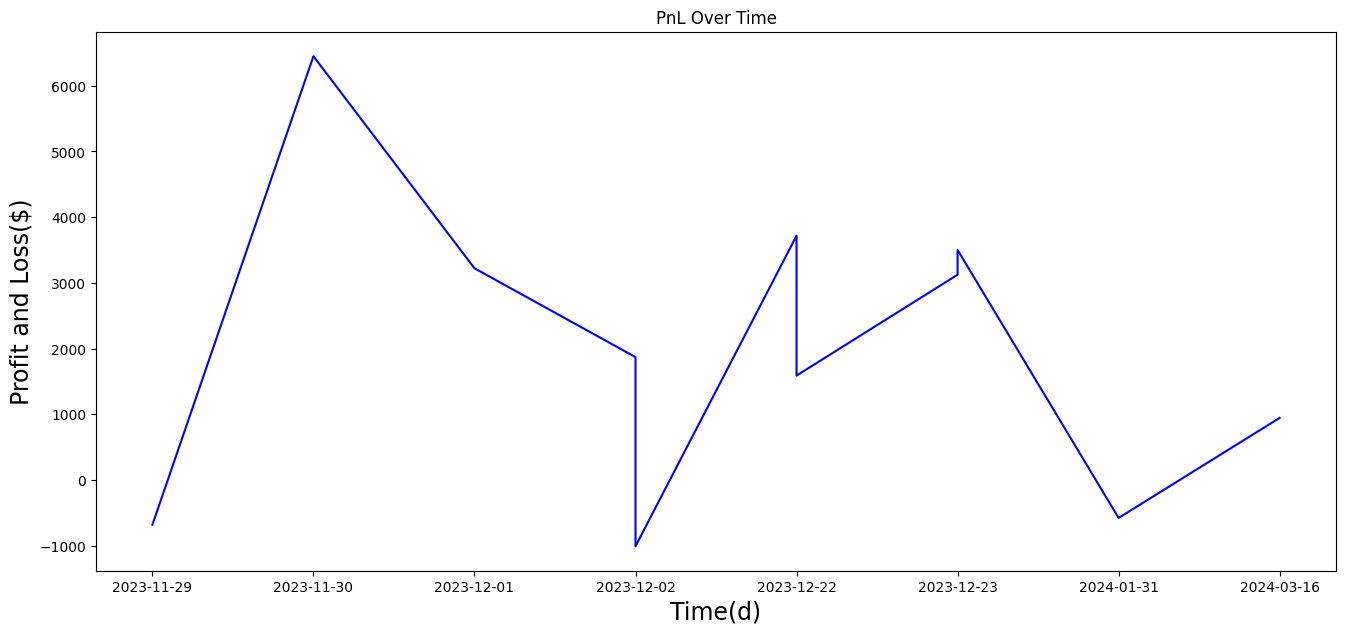

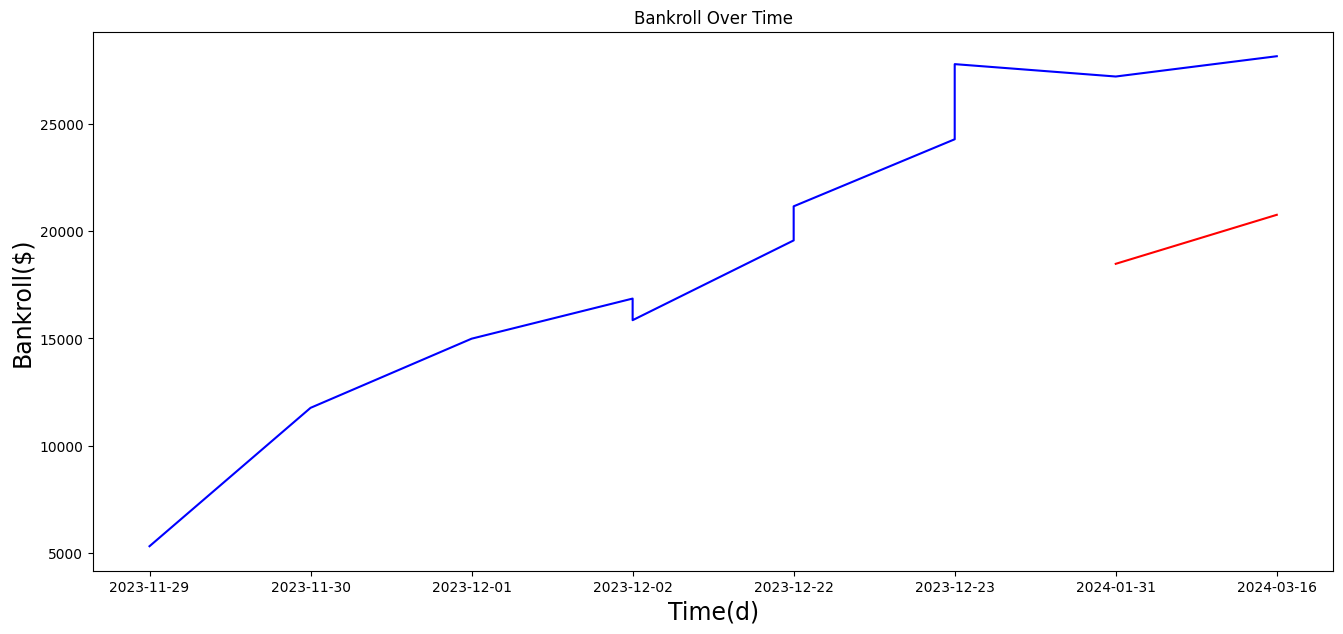



The position was held for 2 months, traded 11 times, and produced a return of 369.2712%.
The growth rate on each bet was 15.0903%.
The final balance is $28156.27.
The average of returns is 246.0784%.
The standard deviation of returns is 93.2603%.


The Sharpe Ratio of the strategy is 2.6386.


In [44]:
threshold_shape = 1.79
spread = 0.41
bet_sharpe = bet[bet['odds_diff'] > spread]
backtest(bet_sharpe, 6000, 0.5, threshold_shape)

In [45]:
bet_sharpe

,Date,Teams,Sportsbooks_Odds,Our_Odds,Probabilities,Predictions,Actual,odds_diff
138,2023-03-26,DAL,1.71,1.272727,0.785714,1,0,0.437273
306,2023-11-29,PHO,2.10,1.680000,0.595238,1,0,0.420000
323,2023-11-29,LAL,1.79,1.375000,0.727273,1,1,0.415000
350,2023-11-30,NYK,3.15,1.000000,1.000000,1,1,2.150000
369,2023-12-01,NOP,2.64,1.272727,0.785714,1,1,1.367273
396,2023-12-02,PHO,2.08,1.281250,0.780488,1,1,0.798750
406,2023-12-02,NOP,2.70,1.718750,0.581818,1,0,0.981250
619,2023-12-22,GSW,2.85,1.272727,0.785714,1,1,1.577273
643,2023-12-22,PHI,1.96,1.281250,0.780488,1,1,0.678750
666,2023-12-23,DAL,2.64,1.293103,0.773333,1,1,1.346897


### 2.2 Calmar Ratio Strategy <a id='2_2'></a>

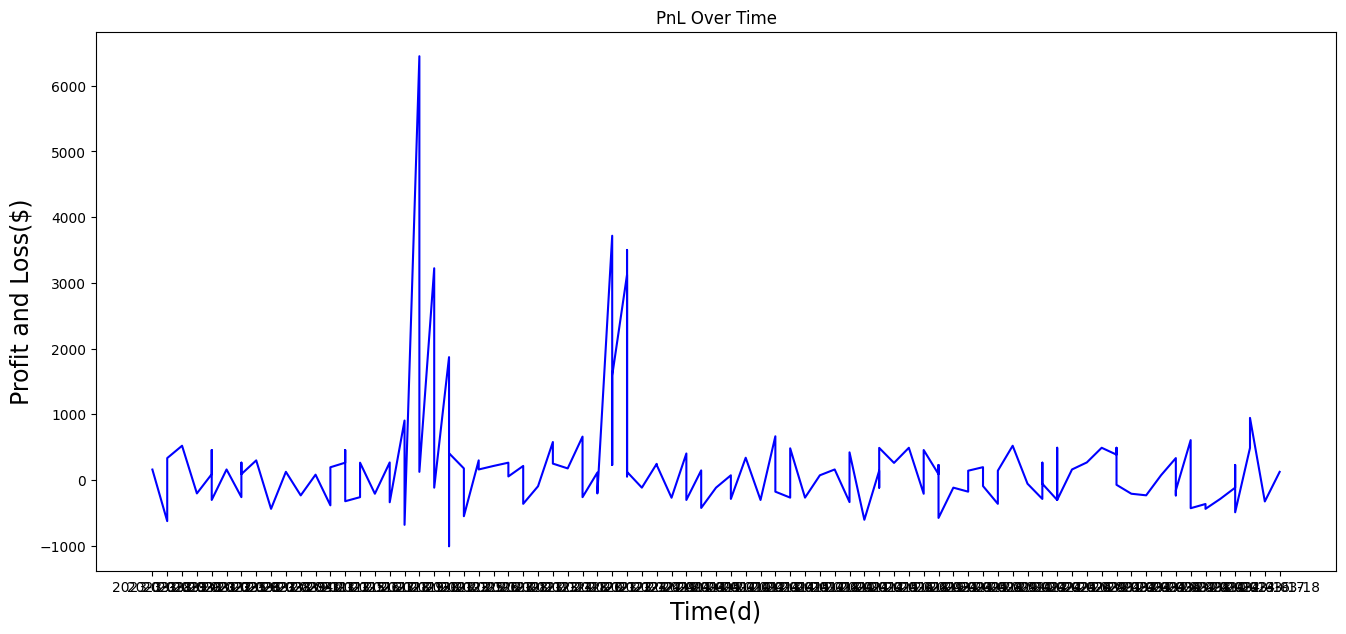

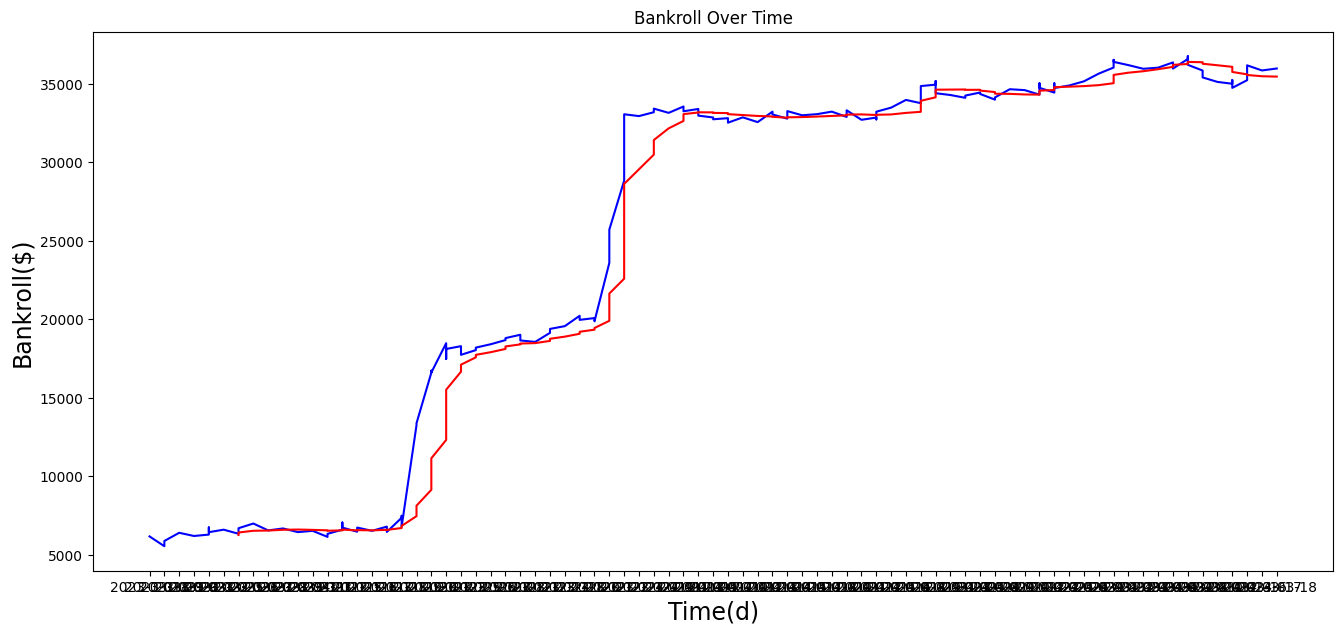



The position was held for 2 months, traded 156 times, and produced a return of 499.3965%.
The growth rate on each bet was 1.1545%.
The final balance is $35963.79.
The average of returns is 334.0803%.
The standard deviation of returns is 186.8393%.


The Sharpe Ratio of the strategy is 1.7881.


In [46]:
threshold_calmar = 1.74
spread = 0.02
bet_calmar = bet[bet['odds_diff'] > spread]
backtest(bet_calmar, 6000, 0.5, threshold_calmar)

In [47]:
bet_calmar

,Date,Teams,Sportsbooks_Odds,Our_Odds,Probabilities,Predictions,Actual,odds_diff
1,2023-03-16,BRK,1.74,1.680000,0.595238,1,0,0.060000
19,2023-03-19,BRK,2.12,1.718750,0.581818,1,0,0.401250
22,2023-03-19,OKC,1.91,1.718750,0.581818,1,1,0.191250
33,2023-03-19,LAL,1.41,1.293103,0.773333,1,1,0.116897
36,2023-03-18,MEM,1.81,1.718750,0.581818,1,1,0.091250
...,...,...,...,...,...,...,...,...
1766,2024-03-17,MIL,1.69,1.611111,0.620690,1,1,0.078889
1780,2024-03-18,PHI,1.79,1.718750,0.581818,1,1,0.071250
1781,2024-03-17,BRK,2.05,1.840000,0.543478,1,0,0.210000
1785,2024-03-20,OKC,1.07,1.000000,1.000000,1,1,0.070000


### 3. Weights Construction <a id='3'></a>

In [53]:
sharpe_p_and_l = p_and_l(bet_sharpe, 6000, 0.5, threshold_shape)
calmar_p_and_l = p_and_l(bet_calmar, 6000, 0.5, threshold_calmar)



The position was held for 2 months, traded 11 times, and produced a return of 369.2712%.
The growth rate on each bet was 15.0903%.
The final balance is $28156.27.
The average of returns is 246.0784%.
The standard deviation of returns is 93.2603%.


The Sharpe Ratio of the strategy is 2.6386.


The position was held for 2 months, traded 156 times, and produced a return of 499.3965%.
The growth rate on each bet was 1.1545%.
The final balance is $35963.79.
The average of returns is 334.0803%.
The standard deviation of returns is 186.8393%.


The Sharpe Ratio of the strategy is 1.7881.


In [54]:
sharpe_p_and_l

,Date,Teams,Sportsbooks_Odds,Our_Odds,Probabilities,Predictions,Actual,odds_diff,Kelly,p_and_l
0,2023-11-29,PHO,2.10,1.680000,0.595238,1,0,0.420000,0.113636,-681.818182
1,2023-11-30,NYK,3.15,1.000000,1.000000,1,1,2.150000,0.500000,6450.000000
2,2023-12-01,NOP,2.64,1.272727,0.785714,1,1,1.367273,0.327526,3222.857143
3,2023-12-02,PHO,2.08,1.281250,0.780488,1,1,0.798750,0.288618,1870.243902
4,2023-12-02,NOP,2.70,1.718750,0.581818,1,0,0.981250,0.167914,-1007.486631
5,2023-12-22,GSW,2.85,1.272727,0.785714,1,1,1.577273,0.334942,3717.857143
6,2023-12-22,PHI,1.96,1.281250,0.780488,1,1,0.678750,0.275915,1589.268293
7,2023-12-23,DAL,2.64,1.293103,0.773333,1,1,1.346897,0.317561,3124.800000
8,2023-12-23,GSW,2.98,1.375000,0.727273,1,1,1.605000,0.294766,3501.818182
9,2024-01-31,BRK,2.30,1.840000,0.543478,1,0,0.460000,0.096154,-576.923077


In [56]:
calmar_p_and_l

,Date,Teams,Sportsbooks_Odds,Our_Odds,Probabilities,Predictions,Actual,odds_diff,Kelly,p_and_l
2,2023-03-18,MEM,1.81,1.71875,0.581818,1,1,0.09125,0.032772,159.272727
0,2023-03-19,BRK,2.12,1.71875,0.581818,1,0,0.40125,0.104221,-625.324675
1,2023-03-19,OKC,1.91,1.71875,0.581818,1,1,0.19125,0.061139,333.818182
3,2023-03-20,CHO,2.16,1.84000,0.543478,1,1,0.32000,0.074963,521.739130
4,2023-03-21,WAS,1.96,1.84000,0.543478,1,0,0.12000,0.033967,-203.804348
...,...,...,...,...,...,...,...,...,...,...
151,2024-03-13,MEM,2.00,1.71875,0.581818,1,0,0.28125,0.081818,-490.909091
152,2024-03-16,GSW,2.14,1.84000,0.543478,1,1,0.30000,0.071510,489.130435
153,2024-03-16,NYK,2.42,1.84000,0.543478,1,1,0.58000,0.110992,945.652174
155,2024-03-17,BRK,2.05,1.84000,0.543478,1,0,0.21000,0.054348,-326.086957
